# sckikit-learn

<img src="../img/scikit.png" alt="guido"  height="150">



## Face Recognition on a subset of the Labeled Faces in the Wild dataset


In [1]:
%pylab inline
import pylab as pl
import numpy as np

Populating the interactive namespace from numpy and matplotlib


## The LFW dataset

Let's start with downloading the data using a scikit-learn utility function.

In [2]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

Let's introspect the images arrays to find the shapes (for plotting with matplotlib)

In [3]:
X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

n_samples, n_features = X.shape
_, h, w = lfw_people.images.shape
n_classes = len(names)

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))

n_samples: 1288
n_features: 1850
n_classes: 7


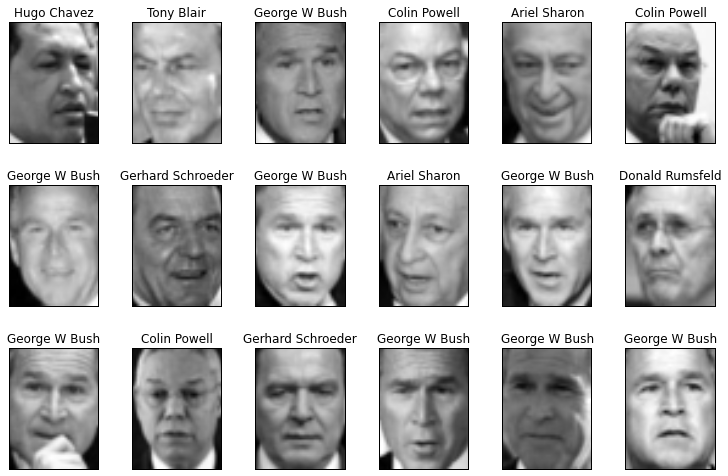

In [4]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

plot_gallery(X, names[y], h, w)

Let's have a look at the repartition among target classes:

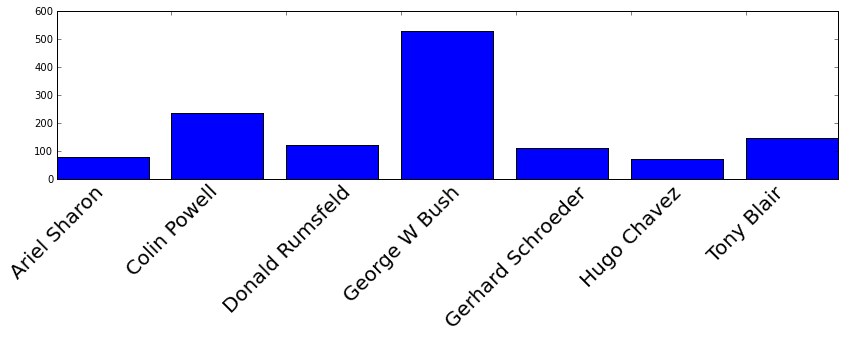

In [5]:
pl.figure(figsize=(14, 3))

y_unique = np.unique(y)
counts = [(y == i).sum() for i in y_unique]

pl.xticks(y_unique,  names[y_unique])
locs, labels = pl.xticks()
pl.setp(labels, rotation=45, size=20)
_ = pl.bar(y_unique, counts)

## Splitting the dataset for model development and then evaluation

Let's split the data in a development set and final evaluation set.

In [6]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Unsupervised Feature Extraction with Randomized PCA

To train a model we will first reduce the dimensionality of the original picture to a 150 PCA space: unsupervised feature extraction.

In [7]:
from sklearn.decomposition import RandomizedPCA

n_components = 150

print "Extracting the top %d eigenfaces from %d faces" % (
    n_components, X_train.shape[0])

pca = RandomizedPCA(n_components=n_components, whiten=True)

%time pca.fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 150 eigenfaces from 966 faces
CPU times: user 524 ms, sys: 56 ms, total: 580 ms
Wall time: 1.04 s


Let's plot the gallery of the most significant eigenfaces:

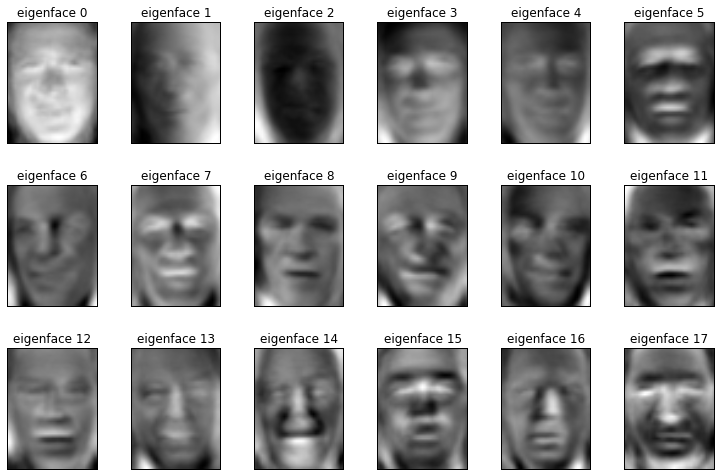

In [8]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

Projecting the input data on the eigenfaces orthonormal basis:

In [9]:
X_train_pca = pca.transform(X_train)

## Training a Gaussian Kernel Support Vector Machine

Let's now train a Kernel Support Vector Machine on the projected data. We perform an automated parameter search to find good values for Gamma and C:

In [10]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', class_weight='auto')

svm

SVC(C=1.0, cache_size=200, class_weight='auto', coef0=0.0, degree=3,
  gamma=0.0, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

Unfortunately an SVM is very sensitive to the parameters C and gamma and it's very unlikely that the default parameters will yield a good predictive accurracy:

In [11]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score

cv = StratifiedShuffleSplit(y_train, test_size=0.20, n_iter=3)

%time svm_cv_scores = cross_val_score(svm, X_train_pca, y_train, scoring='f1', n_jobs=2)
svm_cv_scores

CPU times: user 76 ms, sys: 16 ms, total: 92 ms
Wall time: 583 ms


array([ 0.73430362,  0.78162449,  0.74682483])

In [12]:
svm_cv_scores.mean(), svm_cv_scores.std()

(0.75425098099320065, 0.020019606719342154)

## Data-driven hyper-parameters tuning using a Cross-Validated Grid Search

Fortunately we can automate the search for the best combination of parameters:

In [13]:
from sklearn.grid_search import GridSearchCV

param_grid = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}

clf = GridSearchCV(svm, param_grid, scoring='f1', cv=cv, n_jobs=2)

In [14]:
%time clf = clf.fit(X_train_pca, y_train)

print("Best estimator found by randomized hyper parameter search:")
print(clf.best_params_)
print("Best parameters validation score: {:.3f}".format(clf.best_score_))

CPU times: user 732 ms, sys: 320 ms, total: 1.05 s
Wall time: 12.6 s
Best estimator found by randomized hyper parameter search:
{'C': 5000.0, 'gamma': 0.001}
Best parameters validation score: 0.833


/home/tobie/anaconda/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tobie/anaconda/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Final evaluation of the best model on the held-out test set

Let's start with a qualitative inspection of the some of the predictions:

In [15]:
X_test_pca = pca.transform(X_test)
y_pred = clf.predict(X_test_pca)

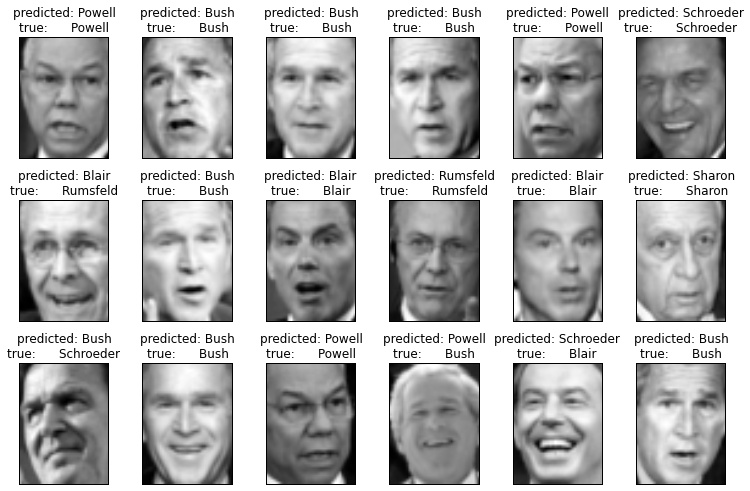

In [16]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.73      0.50      0.59        22
     Colin Powell       0.80      0.81      0.80        58
  Donald Rumsfeld       0.81      0.69      0.75        32
    George W Bush       0.85      0.92      0.88       131
Gerhard Schroeder       0.75      0.83      0.79        29
      Hugo Chavez       1.00      0.83      0.91        18
       Tony Blair       0.79      0.81      0.80        32

      avg / total       0.82      0.82      0.82       322



In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=range(n_classes))
print(cm)

[[ 11   3   2   3   3   0   0]
 [  1  47   0   7   1   0   2]
 [  2   1  22   5   1   0   1]
 [  1   6   2 120   1   0   1]
 [  0   0   1   2  24   0   2]
 [  0   1   0   1   0  15   1]
 [  0   1   0   3   2   0  26]]
